# Air Quality Predictive Modeling & Analysis

**Author:** Cade Teets

**Date:** November 9th, 2025

**Goal:** Predict PM2.5 concentrations using Random Forest Regression and analyze seasonal pollution trends in India (2017-2020), as well as make a Decision Tree Classifier to predict AQI from a selection of the pollutants.

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
# Import data
df_city_day = pd.read_csv('city_day.csv')
df_city_hour = pd.read_csv('city_hour.csv')
df_station_day = pd.read_csv('station_day.csv')
df_station_hour = pd.read_csv('station_hour.csv', dtype={15: str})
df_stations = pd.read_csv('stations.csv')

In [4]:
# Converting date string into datetime objects
df_city_day['Date'] = pd.to_datetime(df_city_day['Date'])
df_station_day['Date'] = pd.to_datetime(df_station_day['Date'])

df_city_hour['Datetime'] = pd.to_datetime(df_city_hour['Datetime'], format='%Y-%m-%d %H:%M:%S')
df_station_hour['Datetime'] = pd.to_datetime(df_station_hour['Datetime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Joining the tables on StationID to add StationName attribute
station_hour_merged_df = pd.merge(
    df_station_hour, #Left relation
    df_stations,     #Right relation
    on='StationId'   #Key for join
)
station_day_merged_df = pd.merge(
    df_station_day,
    df_stations,
    on='StationId'
)
#station_day_merged.head()

In [6]:
# Clean data
attributes_of_interest = [
    'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 
    'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 
    'AQI', 'AQI_Bucket'
]
station_hr_clean = station_hour_merged_df.dropna(
    subset=attributes_of_interest,
    how='any'
).copy()
station_day_clean = station_day_merged_df.dropna(
    subset=attributes_of_interest,
    how='any'
).copy()
# Clean city data
city_hr_clean = df_city_hour.dropna(
    subset=attributes_of_interest,
    how='any'
).copy()
city_day_clean = df_city_day.dropna(
    subset=attributes_of_interest,
    how='any'
).copy()

In [7]:
# Defining a continuous window of analysis for model training
start_date_str = '2017-01-01'
end_date_str = '2020-06-30'
start_datetime_str = '2017-01-01 00:00:00'
end_datetime_str = '2020-07-01 00:00:00'

# Filting the clean DataFrames by the time window
reliable_city_hr_df = city_hr_clean.loc[
    (city_hr_clean['Datetime'] >= start_datetime_str) &
    (city_hr_clean['Datetime'] <= end_datetime_str)
].copy()

reliable_city_day_df = city_day_clean.loc[
    (city_day_clean['Date'] >= start_date_str) &
    (city_day_clean['Date'] <= end_date_str)
].copy()

reliable_station_hr_df = station_hr_clean.loc[
    (station_hr_clean['Datetime'] >= start_datetime_str) &
    (station_hr_clean['Datetime'] <= end_datetime_str)
].copy()

reliable_station_day_df = station_day_clean.loc[
    (station_day_clean['Date'] >= start_date_str) &
    (station_day_clean['Date'] <= end_date_str)
].copy()

print(f"Total reliable city-day rows: {len(reliable_city_day_df)}")
print(f"Total reliable station-hour rows: {len(reliable_station_hr_df)}")

Total reliable city-day rows: 5497
Total reliable station-hour rows: 193132


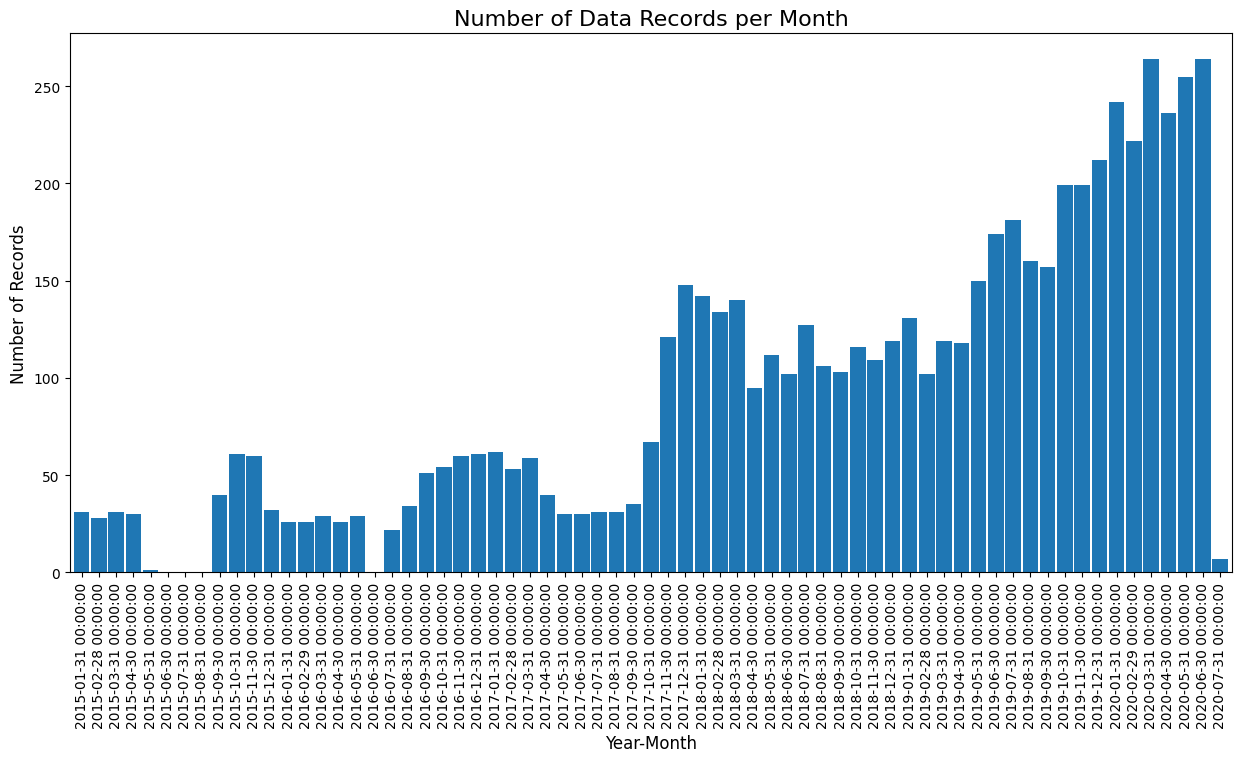

In [8]:
df_for_counting = city_day_clean.copy()
df_for_counting.set_index('Date', inplace=True)

# Resample by 'count' to find the number of data entries
monthly_record_count = df_for_counting['AQI'].resample('M').count()

# Plotting the count:
plt.figure(figsize=(15, 7))
monthly_record_count.plot(kind='bar', width=0.9)
plt.title('Number of Data Records per Month', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.show()

This graph showed me that the data timeline needed to be adjusted to account for the missing data, so that the models will not be skewed. The graph below shows the continous graph made from using the proper timeframe.

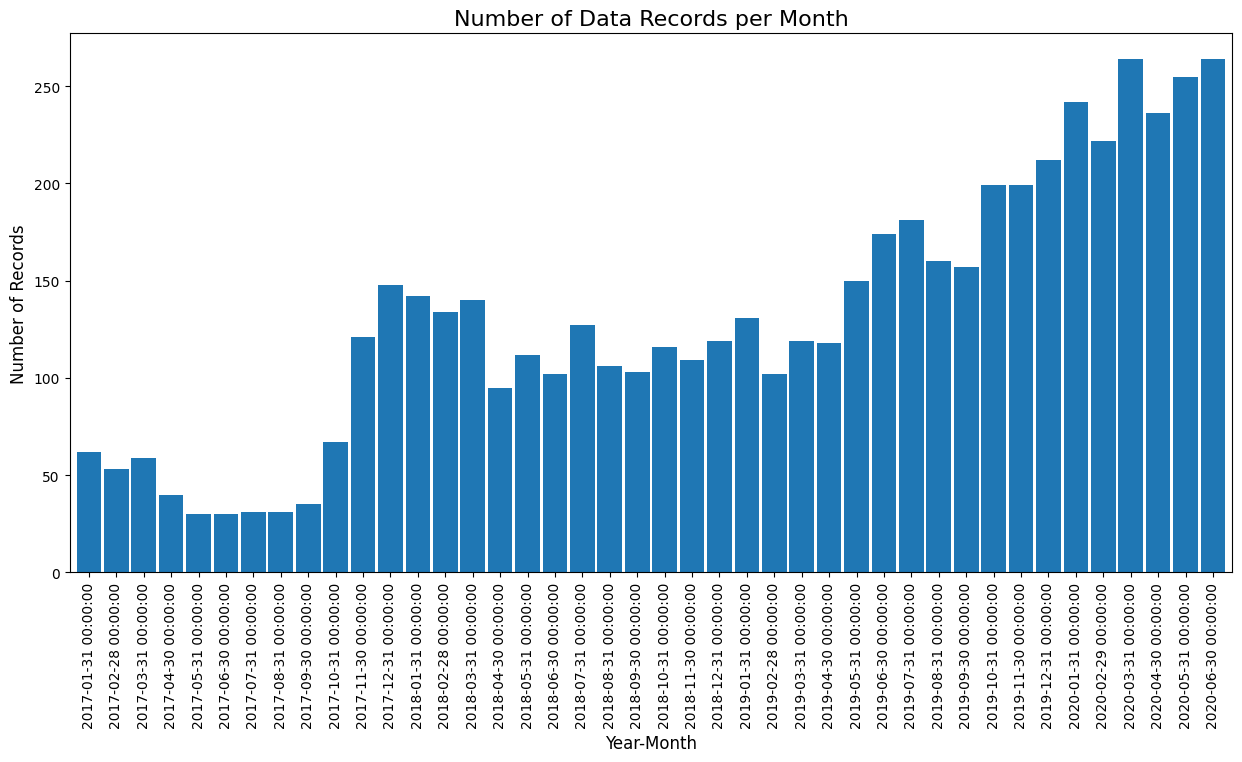

In [9]:
df_for_counting = reliable_city_day_df.copy()
df_for_counting.set_index('Date', inplace=True)

# Resample by 'count' to see how many records we have
monthly_record_count = df_for_counting['AQI'].resample('M').count()

# --- Plot the count ---
plt.figure(figsize=(15, 7))
monthly_record_count.plot(kind='bar', width=0.9)
plt.title('Number of Data Records per Month', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.show()

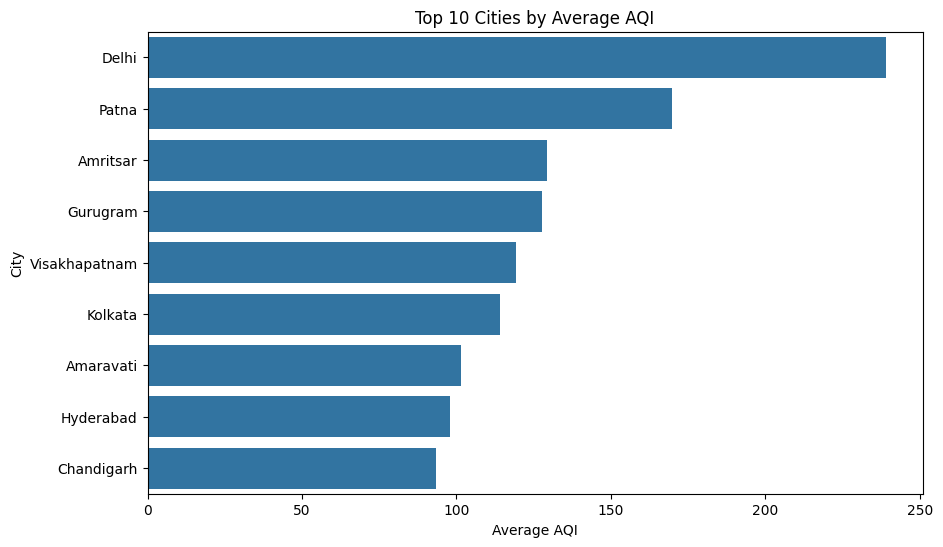

In [10]:
# Find the average AQI for each city
city_avg_aqi = reliable_city_day_df.groupby('City')['AQI'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=city_avg_aqi.head(10).values, 
    y=city_avg_aqi.head(10).index
)
plt.title('Top 10 Cities by Average AQI')
plt.xlabel('Average AQI')
plt.ylabel('City')
plt.show()

In [11]:
# Prepare DataFrame for use in correlation heatmap
numeric_attributes = [
    'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 
    'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 
    'AQI'
]
station_hr_num = reliable_station_hr_df[numeric_attributes]

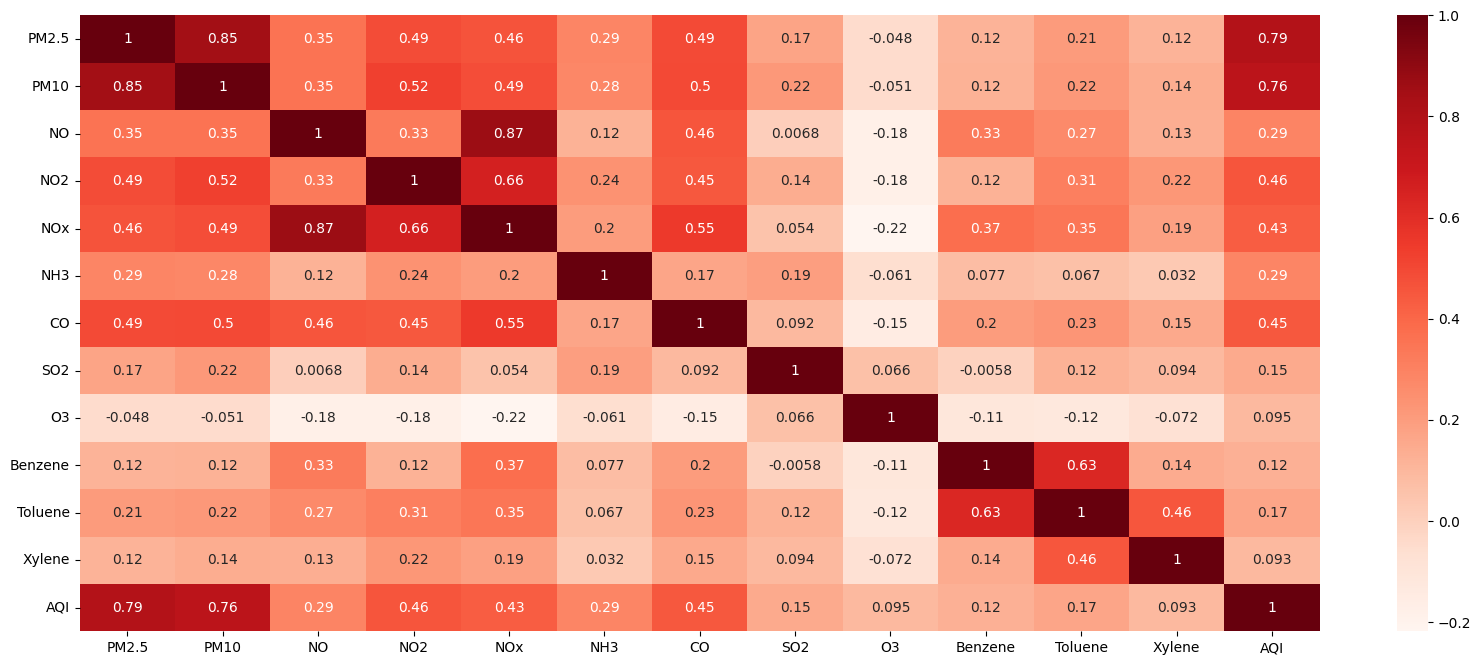

In [12]:
# Analyze correlation map to find trends in the data attributes
plt.figure(figsize=(20,8))
cor = station_hr_num.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) #YlGnBu
plt.show()

At this point I was wondering if NOx was a sum of the NO and NO2, so this code proves that NOx is not a sum. By calculating the difference and observing that the mean residual was not zero, I confirmed that NOx represents a more complex chemical measurement or a different sensing method rather than a direct summation of the other two variables.

Statistical Summary of NOx Residuals (Recorded - Calculated):
count    193132.000000
mean        -14.954683
std          16.416546
min        -445.060000
25%         -21.690000
50%         -10.890000
75%          -3.820000
max         193.770000
Name: NOx_Residual, dtype: float64
Distribution Skewness: -3.0197

Verdict: NOx is NOT a simple sum (Mean Residual: -14.95).
Observation: The negative skew confirms a systematic 'over-summing' where NO + NO2 often exceeds the reported NOx.
This confirms NOx represents a separate measurement or complex chemical aggregate.


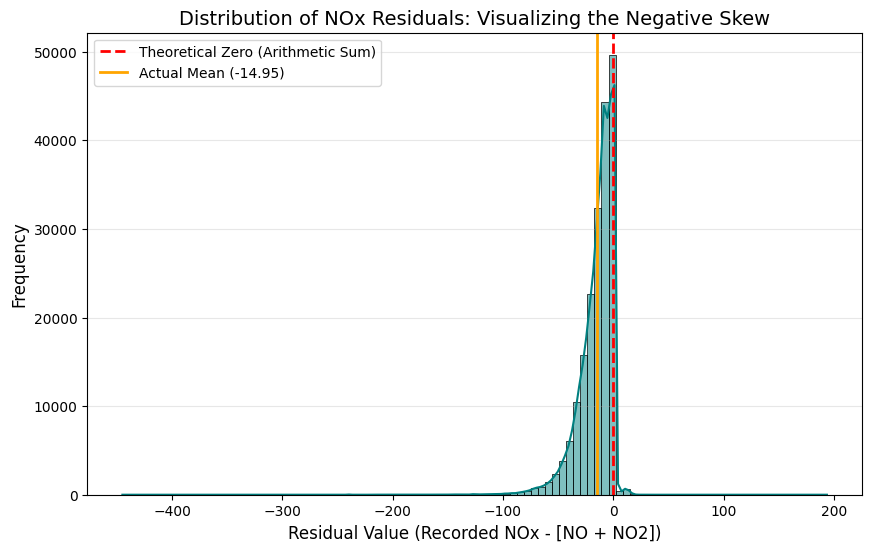

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Calculate the residual between recorded NOx and the arithmetic sum of NO + NO2
# If NOx was a simple sum, this residual would be zero for all observations
reliable_station_hr_df['NOx_Residual'] = reliable_station_hr_df['NOx'] - (reliable_station_hr_df['NO'] + reliable_station_hr_df['NO2'])

# Generate a statistical summary of the differences
residual_stats = reliable_station_hr_df['NOx_Residual'].describe()
mean_residual = reliable_station_hr_df['NOx_Residual'].mean()
skewness_val = skew(reliable_station_hr_df['NOx_Residual'].dropna())

print("Statistical Summary of NOx Residuals (Recorded - Calculated):")
print(residual_stats)
print(f"Distribution Skewness: {skewness_val:.4f}")

# Print a definitive verdict based on the mean residual and skewness
# A negative mean and left skew indicate the sum consistently exceeds the total NOx
if abs(mean_residual) > 0.1:
    print(f"\nVerdict: NOx is NOT a simple sum (Mean Residual: {mean_residual:.2f}).")
    if skewness_val < 0:
        print("Observation: The negative skew confirms a systematic 'over-summing' where NO + NO2 often exceeds the reported NOx.")
    print("This confirms NOx represents a separate measurement or complex chemical aggregate.")
else:
    print("\nVerdict: NOx appears to be an arithmetic sum of NO and NO2.")

# Visualize the distribution of residuals
# The left-skewed peak visually proves the deviation from the theoretical zero
plt.figure(figsize=(10, 6))
sns.histplot(reliable_station_hr_df['NOx_Residual'].dropna(), bins=100, color='teal', kde=True)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Theoretical Zero (Arithmetic Sum)')
plt.axvline(mean_residual, color='orange', linestyle='-', linewidth=2, label=f'Actual Mean ({mean_residual:.2f})')

plt.title('Distribution of NOx Residuals: Visualizing the Negative Skew', fontsize=14)
plt.xlabel('Residual Value (Recorded NOx - [NO + NO2])', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

### Visualizing the Average AQI Trend

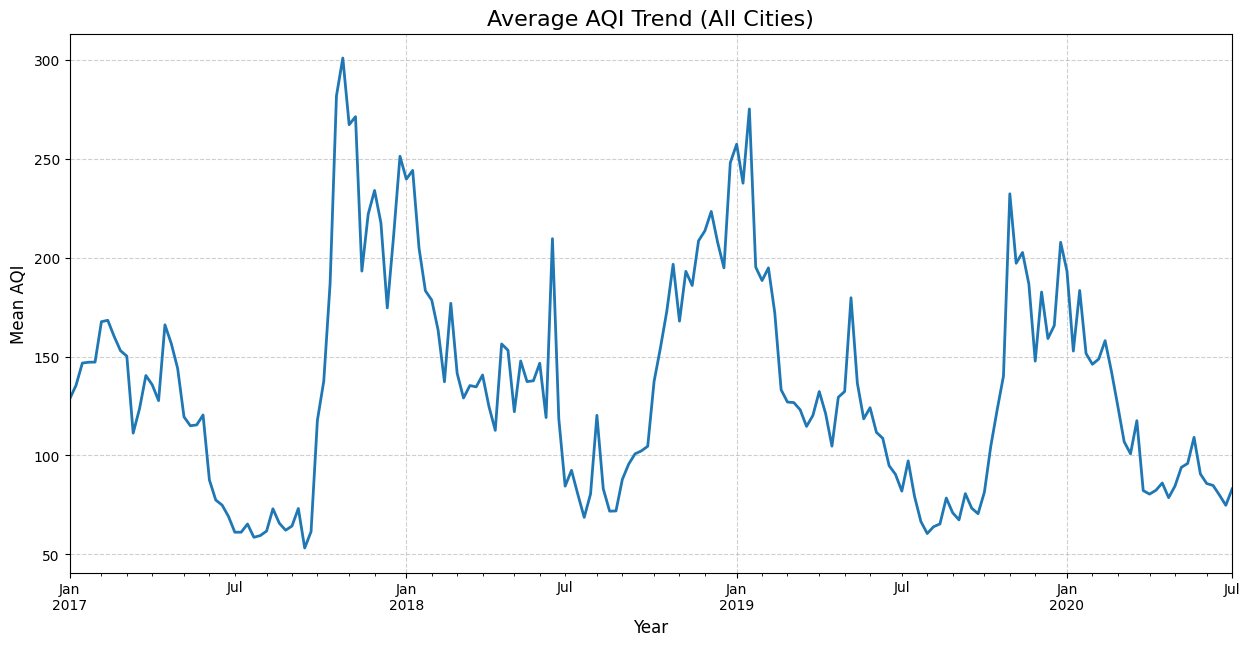

In [ ]:
df_for_plot = reliable_city_day_df.copy()

# Set your 'Date' as the index
df_for_plot.set_index('Date', inplace=True)

# Calculate the average AQI across all cities for each day, one data point per day
daily_mean_aqi = df_for_plot.groupby('Date')['AQI'].mean()

# Resample to get the weekly average, smoothing out noise
weekly_mean_aqi = daily_mean_aqi.resample('W').mean()

# Plotting the trend
plt.figure(figsize=(15, 7))
weekly_mean_aqi.plot(linewidth=2)

plt.title('Average AQI Trend (All Cities)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean AQI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The climate in India is dominated by the monsoon weather patterns that cycle the weather between the monsoon season where its raining and windy, and a dry and stagnant air post monsoon. 

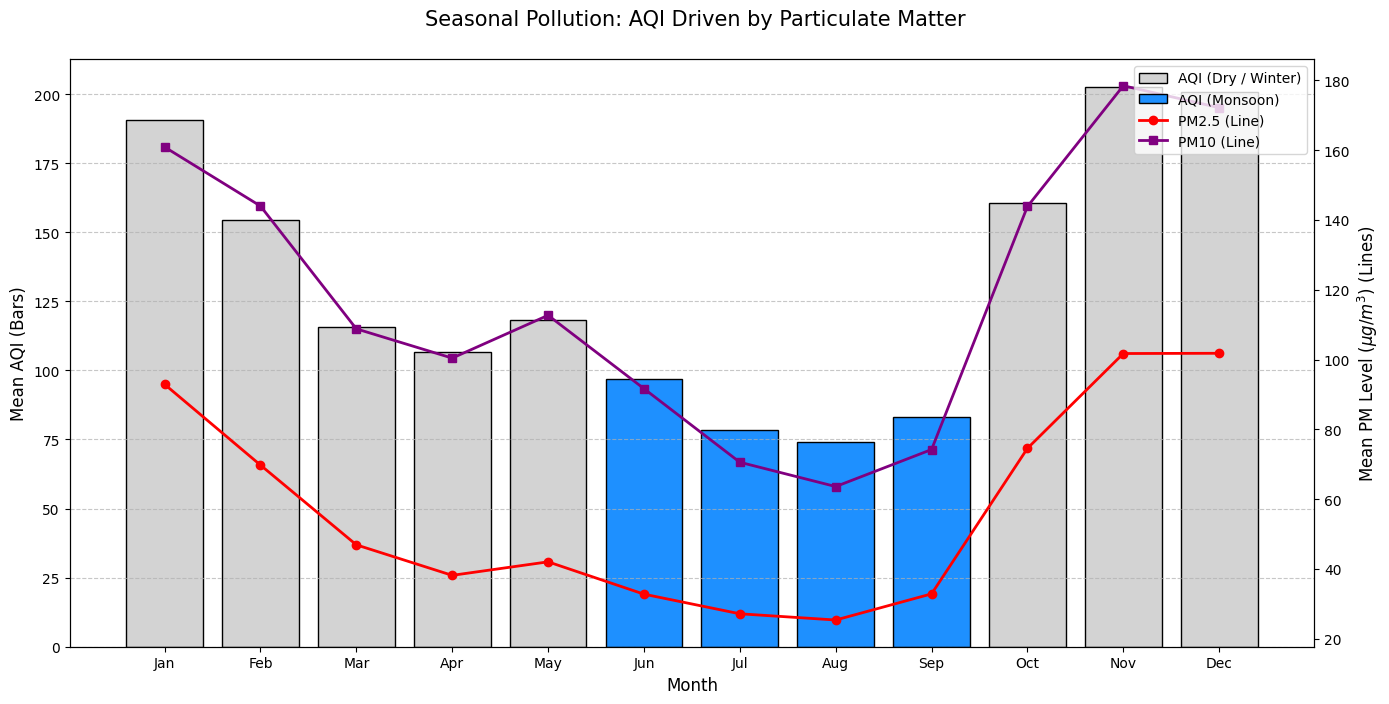

In [32]:
# Group by month to evalute by season
df_for_seasonal_plot = reliable_city_day_df.copy()
df_for_seasonal_plot['Month'] = df_for_seasonal_plot['Date'].dt.month
seasonal_trends = df_for_seasonal_plot.groupby('Month')[['AQI', 'PM2.5', 'PM10']].mean()

# Split the data for plotting of monsoon season
monsoon_months = [6, 7, 8, 9]

# Get data for monsoon months
monsoon_data = seasonal_trends.loc[seasonal_trends.index.isin(monsoon_months)]
# Get data for non-monsoon months
non_monsoon_data = seasonal_trends.loc[~seasonal_trends.index.isin(monsoon_months)]

# Plot the Dual-Axis Chart:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot 1: AQI Bar Chart (on the left axis, ax1)

# Plot the Non-Monsoon bars first (in grey)
ax1.bar(
    non_monsoon_data.index,
    non_monsoon_data['AQI'],
    color='lightgrey',
    edgecolor='black',
    label='AQI (Dry / Winter)'
)
# Plot the Monsoon bars second (in blue)
ax1.bar(
    monsoon_data.index,
    monsoon_data['AQI'],
    color='dodgerblue',
    edgecolor='black',
    label='AQI (Monsoon)'
)

ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Mean AQI (Bars)', fontsize=12)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: PM Line Charts (on the right axis, ax2)
ax2 = ax1.twinx()
ax2.plot(
    seasonal_trends.index,
    seasonal_trends['PM2.5'],
    color='red',
    marker='o',
    linewidth=2,
    label='PM2.5 (Line)'
)
ax2.plot(
    seasonal_trends.index,
    seasonal_trends['PM10'],
    color='purple',
    marker='s',
    linewidth=2,
    label='PM10 (Line)'
)
ax2.set_ylabel('Mean PM Level ($\mu g/m^3$) (Lines)', fontsize=12)

# Add legends and title
fig.suptitle('Seasonal Pollution: AQI Driven by Particulate Matter', fontsize=15, y=1)

# This collects all the labels from both axes and puts them in one box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

fig.tight_layout() 
plt.show()

Looking at the hourly data sets to see the trends caused by traffic

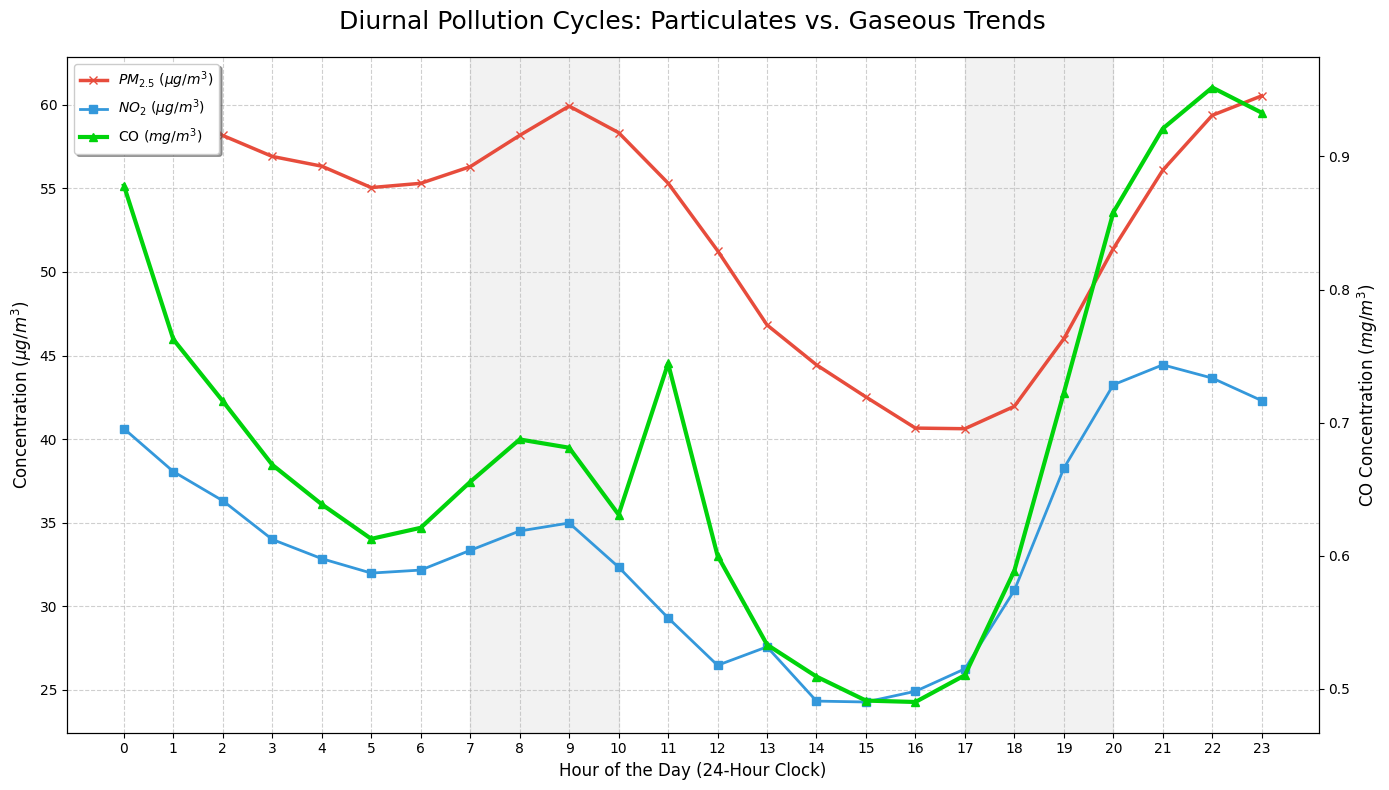

In [40]:
# Preparing the Data
df_for_hourly_plot = reliable_station_hr_df.copy()
df_for_hourly_plot['Hour'] = df_for_hourly_plot['Datetime'].dt.hour

# Group by Hour and get the average pollutant concentrations
# Removed AQI to focus strictly on physical units (ug/m3 and mg/m3)
hourly_trend = df_for_hourly_plot.groupby('Hour')[['NO2', 'CO', 'PM2.5']].mean()

# Initializing the Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plotting Primary Axis (Left)
# PM2.5 and NO2 share the same units (micrograms per cubic meter)
line1 = ax1.plot(hourly_trend.index, hourly_trend['PM2.5'], 
                 linewidth=2.5, marker='x', color='#e74c3c', label='$PM_{2.5}$ ($\mu g/m^3$)')
line2 = ax1.plot(hourly_trend.index, hourly_trend['NO2'], 
                 linewidth=2, marker='s', color='#3498db', label='$NO_2$ ($\mu g/m^3$)')

# Setting labels and grid for the Left Axis
ax1.set_xlabel('Hour of the Day (24-Hour Clock)', fontsize=12)
ax1.set_ylabel('Concentration ($\mu g/m^3$)', fontsize=12)
ax1.set_xticks(range(0, 24))
ax1.grid(True, linestyle='--', alpha=0.6)

# Plotting Secondary Axis (Right)
# CO is measured in mg/m3; its own axis reveals trends hidden by the larger scale of PM2.5
ax2 = ax1.twinx()
# Using Deep Orange instead of Yellow for better visibility
line3 = ax2.plot(hourly_trend.index, hourly_trend['CO'], 
                 linewidth=3, marker='^', color="#00d30b", label='CO ($mg/m^3$)')

# Setting labels for the Right Axis with matching high-contrast color
ax2.set_ylabel('CO Concentration ($mg/m^3$)', fontsize=12)
ax2.tick_params(axis='y')

# Cleaning up Layout and Legend
plt.title('Diurnal Pollution Cycles: Particulates vs. Gaseous Trends', fontsize=18, pad=20)

# Merging legends from both axes into a single box
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', frameon=True, shadow=True)

# Adding Rush Hour Highlights to show the link to traffic patterns
ax1.axvspan(7, 10, color='gray', alpha=0.1, label='Morning Rush')
ax1.axvspan(17, 20, color='gray', alpha=0.1, label='Evening Rush')

plt.tight_layout()
plt.show()

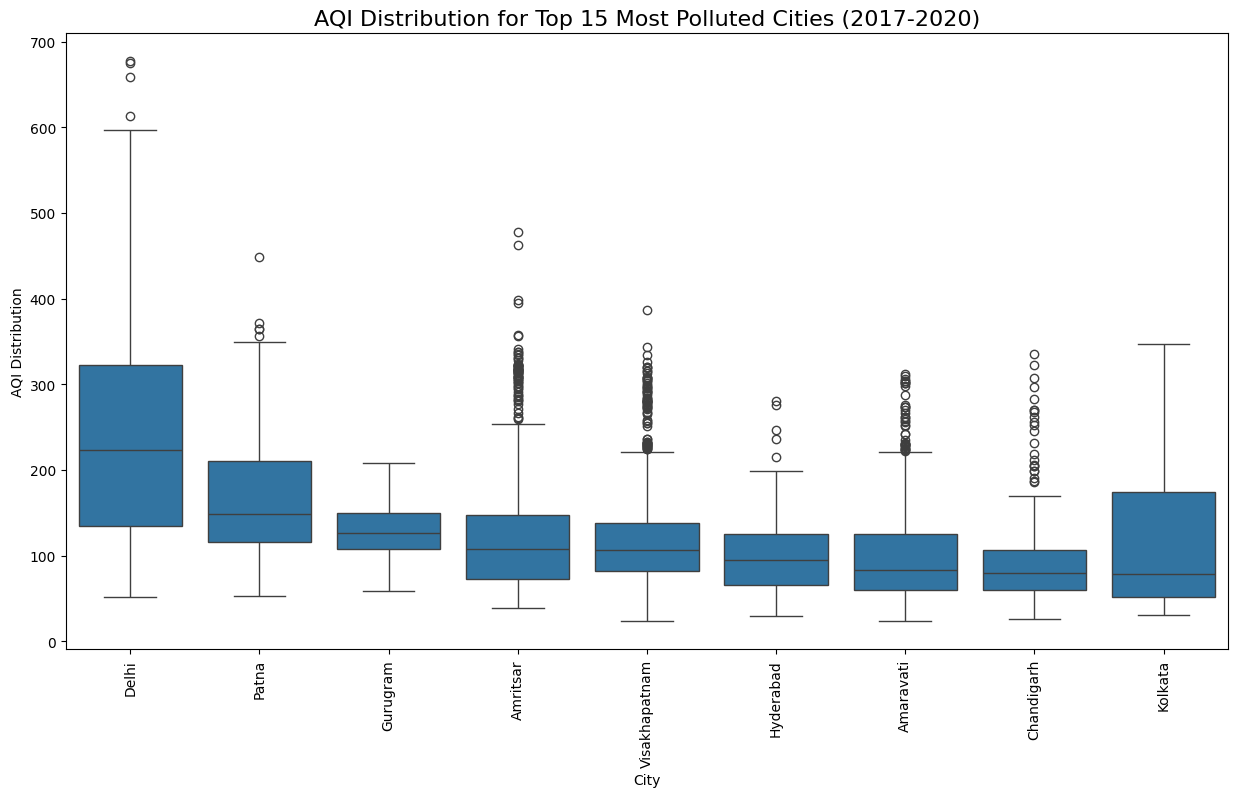

In [ ]:
# Get the Top 15 Most Polluted Cities

# Find the median AQI for each city
city_median_aqi = reliable_city_day_df.groupby('City')['AQI'].median().sort_values(ascending=False)

# Get the names of the top 15
top_15_cities = city_median_aqi.head(15).index

# Filter your dataframe to these 15 cities
top_15_df = reliable_city_day_df[reliable_city_day_df['City'].isin(top_15_cities)]

# Creating box plot:
plt.figure(figsize=(15, 8))
sns.boxplot(
    x='City', 
    y='AQI', 
    data=top_15_df, 
    order=top_15_cities # Order the plot from most to least polluted
)
plt.title('AQI Distribution for Top 15 Most Polluted Cities (2017-2020)', fontsize=16)
plt.xticks(rotation=90) # Rotate city names
plt.ylabel('AQI Distribution')
plt.xlabel('City')
plt.show()

# Machine Learning Models

## Linear Regression Model to Predict PM2.5

In [41]:
# Define the features and target variable
features_list = ['NO2', 'CO', 'SO2', 'O3', 'NH3']
target_col = 'PM2.5'

# Create a focused DataFrame
# Combine the feature list and the target to slice the primary dataset
model_data = reliable_station_hr_df[features_list + [target_col]]

# Remove rows with missing data in this specific subset
# Ensure the model only trains on complete records to maintain accuracy
model_data_clean = model_data.dropna()

print(f"Using {len(model_data_clean)} rows for modeling.")

# Assign the X and y variables
# X contains the predictors and y contains the target PM2.5 values
X = model_data_clean[features_list]
y = model_data_clean[target_col]

Using 193132 rows for modeling.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lin_reg.predict(X_test)

# Evaluate the performance
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

print(f"Linear Regression Model R-squared: {r2:.4f}")
print(f"Linear Regression Model Mean Squared Error: {MSE:.4f}")


Linear Regression Model R-squared: 0.3835
Linear Regression Model Mean Squared Error: 1445.5088


## Random Forest Regression Models to predict PM2.5:

### Random Forest Regressor Model V1 (Pollutant Gasses, No VOC's)

Original clean data rows: 193132
Using 50000 rows for training...
Training Random Forest...
Training Complete.

Random Forest Model V1 Results:
  R-squared: 0.5137
  MSE:       1041.5451
  RMSE:      32.27 µg/m³


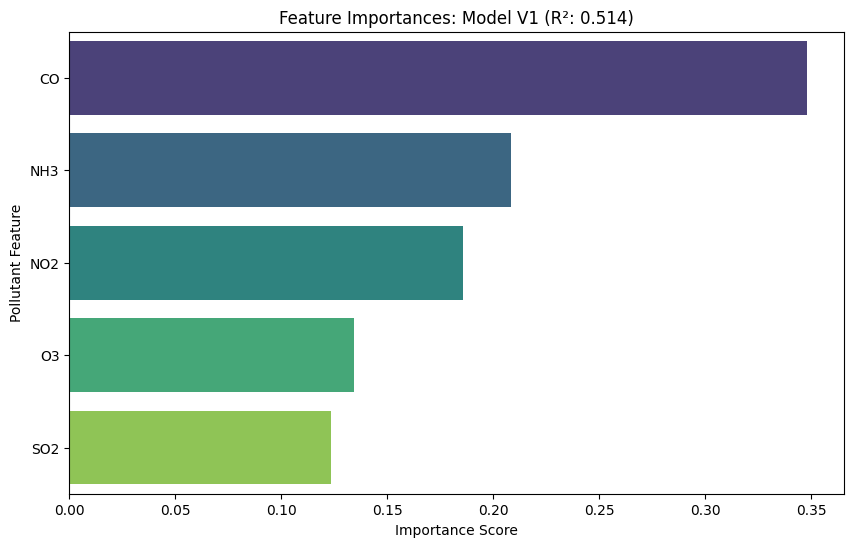


Sorted Feature Importances:
Feature  Importance
     CO    0.348120
    NH3    0.208314
    NO2    0.185702
     O3    0.134315
    SO2    0.123549


In [48]:
# Define features and target variable
features_list = ['NO2', 'CO', 'SO2', 'O3', 'NH3']
target_col = 'PM2.5'

# Filter dataset and remove missing values
model_data = reliable_station_hr_df[features_list + [target_col]]
model_data_clean = model_data.dropna()

# Sample data for computational efficiency
# Use 50,000 random rows to optimize training speed
n_samples = 50000
if len(model_data_clean) > n_samples:
    model_data_sample = model_data_clean.sample(n=n_samples, random_state=42)
else:
    model_data_sample = model_data_clean.copy()

print(f"Original clean data rows: {len(model_data_clean)}")
print(f"Using {len(model_data_sample)} rows for training...")

# Assign feature and target variables
X = model_data_sample[features_list]
y = model_data_sample[target_col]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
# Use n_jobs=-1 to utilize all CPU cores for faster execution
print("Training Random Forest...")
rf_reg = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)
print("Training Complete.")

# Evaluate model performance
y_pred_rf = rf_reg.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"\nRandom Forest Model V1 Results:")
print(f"  R-squared: {r2_rf:.4f}")
print(f"  MSE:       {mse_rf:.4f}")
print(f"  RMSE:      {rmse_rf:.2f} µg/m³")

# Analyze and visualize feature importances
importances = rf_reg.feature_importances_
feature_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create bar plot for visual comparison
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_df, 
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title(f'Feature Importances: Model V1 (R²: {r2_rf:.3f})')
plt.xlabel('Importance Score')
plt.ylabel('Pollutant Feature')
plt.show()

# Print importance values for detailed review
print("\nSorted Feature Importances:")
print(feature_df.to_string(index=False))

### Model V2 (Gases + VOCs)

Original clean data rows: 193132
Using 50000 rows for training...
Training Random Forest V2...
Training Complete.

Random Forest Model V2 Results:
  R-squared: 0.6414
  MSE:       768.0403
  RMSE:      27.71 µg/m³


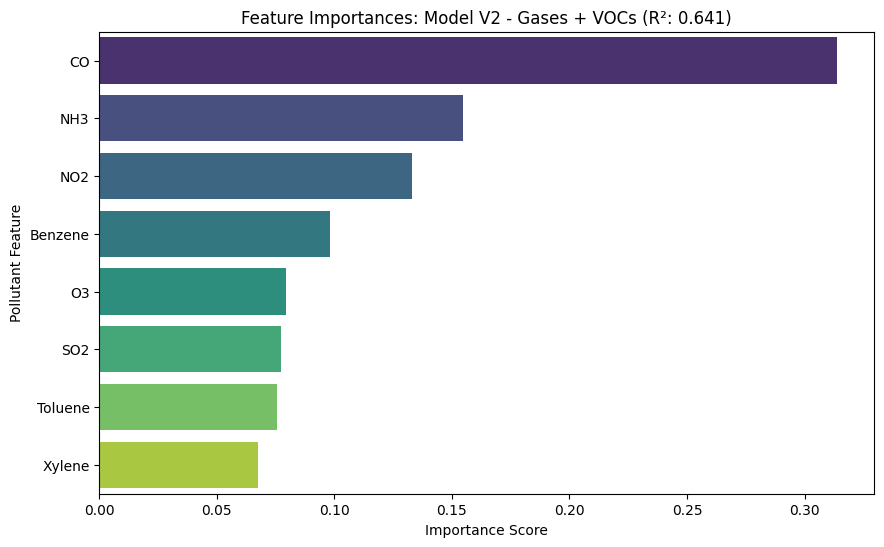


Sorted Feature Importances (Model V2):
Feature  Importance
     CO    0.313959
    NH3    0.154571
    NO2    0.132976
Benzene    0.098164
     O3    0.079482
    SO2    0.077501
Toluene    0.075803
 Xylene    0.067544


In [50]:
# Define features including standard gases and VOCs (Benzene, Toluene, Xylene)
features_list_v2 = ['NO2', 'CO', 'SO2', 'O3', 'NH3', 'Benzene', 'Toluene', 'Xylene']
target_col = 'PM2.5'

# Filter dataset and remove missing values for the expanded feature set
model_data_v2 = reliable_station_hr_df[features_list_v2 + [target_col]].dropna()

# Sample data to maintain consistent computational speed
n_samples = 50000
if len(model_data_v2) > n_samples:
    model_data_sample_v2 = model_data_v2.sample(n=n_samples, random_state=42)
else:
    model_data_sample_v2 = model_data_v2.copy()

print(f"Original clean data rows: {len(model_data_v2)}")
print(f"Using {len(model_data_sample_v2)} rows for training...")

# Assign feature and target variables
X_v2 = model_data_sample_v2[features_list_v2]
y_v2 = model_data_sample_v2[target_col]

# Split data into training and testing sets
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# Train the Random Forest model for V2
print("Training Random Forest V2...")
rf_reg_v2 = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_reg_v2.fit(X_train_v2, y_train_v2)
print("Training Complete.")

# Evaluate model performance and calculate RMSE
y_pred_rf_v2 = rf_reg_v2.predict(X_test_v2)
r2_rf_v2 = r2_score(y_test_v2, y_pred_rf_v2)
mse_v2 = mean_squared_error(y_test_v2, y_pred_rf_v2)
rmse_v2 = np.sqrt(mse_v2)

print(f"\nRandom Forest Model V2 Results:")
print(f"  R-squared: {r2_rf_v2:.4f}")
print(f"  MSE:       {mse_v2:.4f}")
print(f"  RMSE:      {rmse_v2:.2f} µg/m³")

# Extract and rank feature importances
importances_v2 = rf_reg_v2.feature_importances_
feature_df_v2 = pd.DataFrame({
    'Feature': features_list_v2,
    'Importance': importances_v2
}).sort_values(by='Importance', ascending=False)

# Visualize feature importances with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_df_v2, 
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title(f'Feature Importances: Model V2 - Gases + VOCs (R²: {r2_rf_v2:.3f})')
plt.xlabel('Importance Score')
plt.ylabel('Pollutant Feature')
plt.show()

# Print importance values for detailed review
print("\nSorted Feature Importances (Model V2):")
print(feature_df_v2.to_string(index=False))

### Model V3 (Gases + PM10)

Original clean data rows: 193132
Using 50000 rows for training...
Training Random Forest V3...
Training Complete.

Random Forest Model V3 Results:
  R-squared: 0.7965
  MSE:       435.9889
  RMSE:      20.88 µg/m³


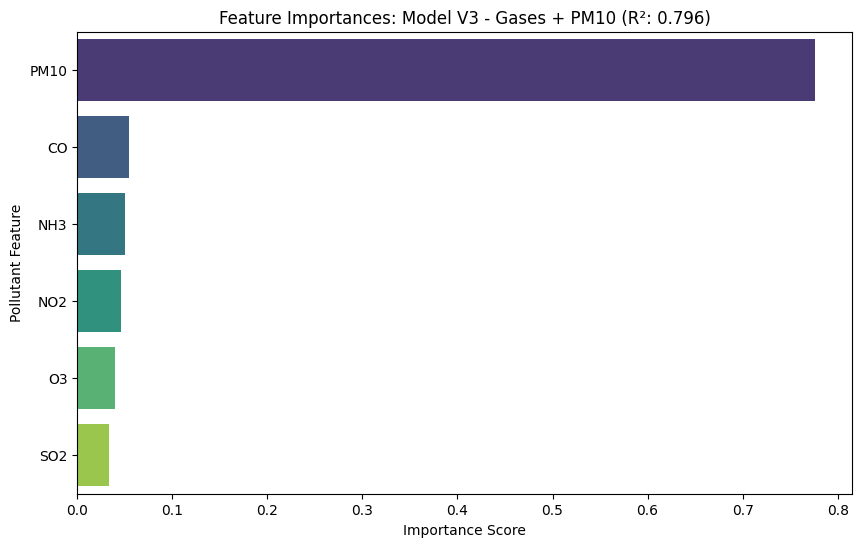


Sorted Feature Importances (Model V3):
Feature  Importance
   PM10    0.776526
     CO    0.054405
    NH3    0.050076
    NO2    0.046039
     O3    0.039190
    SO2    0.033763


In [51]:
# Define features including standard gases and PM10
features_list_v3 = ['NO2', 'CO', 'SO2', 'O3', 'NH3', 'PM10']
target_col = 'PM2.5'

# Filter dataset and remove missing values for this feature set
model_data_v3 = reliable_station_hr_df[features_list_v3 + [target_col]].dropna()

# Sample data to maintain consistent computational speed
n_samples = 50000
if len(model_data_v3) > n_samples:
    model_data_sample_v3 = model_data_v3.sample(n=n_samples, random_state=42)
else:
    model_data_sample_v3 = model_data_v3.copy()

print(f"Original clean data rows: {len(model_data_v3)}")
print(f"Using {len(model_data_sample_v3)} rows for training...")

# Assign feature and target variables
X_v3 = model_data_sample_v3[features_list_v3]
y_v3 = model_data_sample_v3[target_col]

# Split data into training and testing sets
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_v3, y_v3, test_size=0.2, random_state=42)

# Train the Random Forest model for V3
print("Training Random Forest V3...")
rf_reg_v3 = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_reg_v3.fit(X_train_v3, y_train_v3)
print("Training Complete.")

# Evaluate model performance and calculate RMSE
y_pred_rf_v3 = rf_reg_v3.predict(X_test_v3)
r2_rf_v3 = r2_score(y_test_v3, y_pred_rf_v3)
mse_v3 = mean_squared_error(y_test_v3, y_pred_rf_v3)
rmse_v3 = np.sqrt(mse_v3)

print(f"\nRandom Forest Model V3 Results:")
print(f"  R-squared: {r2_rf_v3:.4f}")
print(f"  MSE:       {mse_v3:.4f}")
print(f"  RMSE:      {rmse_v3:.2f} µg/m³")

# Extract and rank feature importances
importances_v3 = rf_reg_v3.feature_importances_
feature_df_v3 = pd.DataFrame({
    'Feature': features_list_v3,
    'Importance': importances_v3
}).sort_values(by='Importance', ascending=False)

# Visualize feature importances with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_df_v3, 
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title(f'Feature Importances: Model V3 - Gases + PM10 (R²: {r2_rf_v3:.3f})')
plt.xlabel('Importance Score')
plt.ylabel('Pollutant Feature')
plt.show()

# Print importance values for detailed review
print("\nSorted Feature Importances (Model V3):")
print(feature_df_v3.to_string(index=False))

### Model V4 (Gases + PM10 + VOCs)

Original clean data rows: 193132
Using 50000 rows for training...
Training Random Forest V4...
Training Complete.

Random Forest Model V4 Results:
  R-squared: 0.8140
  MSE:       398.3556
  RMSE:      19.96 µg/m³


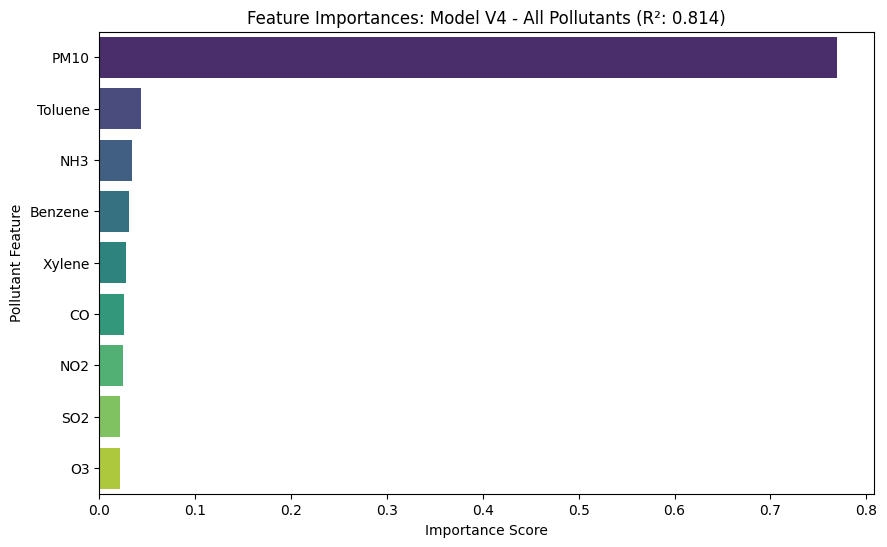


Sorted Feature Importances (Model V4):
Feature  Importance
   PM10    0.769854
Toluene    0.043829
    NH3    0.034087
Benzene    0.031246
 Xylene    0.028378
     CO    0.025493
    NO2    0.024609
    SO2    0.021366
     O3    0.021138


In [52]:
# Define the comprehensive feature list: Gases, VOCs, and PM10
features_list_v4 = ['NO2', 'CO', 'SO2', 'O3', 'NH3', 'PM10', 'Benzene', 'Toluene', 'Xylene']
target_col = 'PM2.5'

# Filter dataset and remove missing values for the full feature set
model_data_v4 = reliable_station_hr_df[features_list_v4 + [target_col]].dropna()

# Sample data to maintain consistent computational speed across experiments
n_samples = 50000
if len(model_data_v4) > n_samples:
    model_data_sample_v4 = model_data_v4.sample(n=n_samples, random_state=42)
else:
    model_data_sample_v4 = model_data_v4.copy()

print(f"Original clean data rows: {len(model_data_v4)}")
print(f"Using {len(model_data_sample_v4)} rows for training...")

# Assign feature and target variables
X_v4 = model_data_sample_v4[features_list_v4]
y_v4 = model_data_sample_v4[target_col]

# Split data into training and testing sets
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(X_v4, y_v4, test_size=0.2, random_state=42)

# Train the Random Forest model for V4 utilizing all CPU cores
print("Training Random Forest V4...")
rf_reg_v4 = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_reg_v4.fit(X_train_v4, y_train_v4)
print("Training Complete.")

# Evaluate model performance and calculate RMSE
y_pred_rf_v4 = rf_reg_v4.predict(X_test_v4)
r2_rf_v4 = r2_score(y_test_v4, y_pred_rf_v4)
mse_v4 = mean_squared_error(y_test_v4, y_pred_rf_v4)
rmse_v4 = np.sqrt(mse_v4)

print(f"\nRandom Forest Model V4 Results:")
print(f"  R-squared: {r2_rf_v4:.4f}")
print(f"  MSE:       {mse_v4:.4f}")
print(f"  RMSE:      {rmse_v4:.2f} µg/m³")

# Extract and rank feature importances to identify key drivers
importances_v4 = rf_reg_v4.feature_importances_
feature_df_v4 = pd.DataFrame({
    'Feature': features_list_v4,
    'Importance': importances_v4
}).sort_values(by='Importance', ascending=False)

# Visualize feature importances with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_df_v4, 
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title(f'Feature Importances: Model V4 - All Pollutants (R²: {r2_rf_v4:.3f})')
plt.xlabel('Importance Score')
plt.ylabel('Pollutant Feature')
plt.show()

# Print importance values for detailed quantitative review
print("\nSorted Feature Importances (Model V4):")
print(feature_df_v4.to_string(index=False))

## Visualization of Model V3

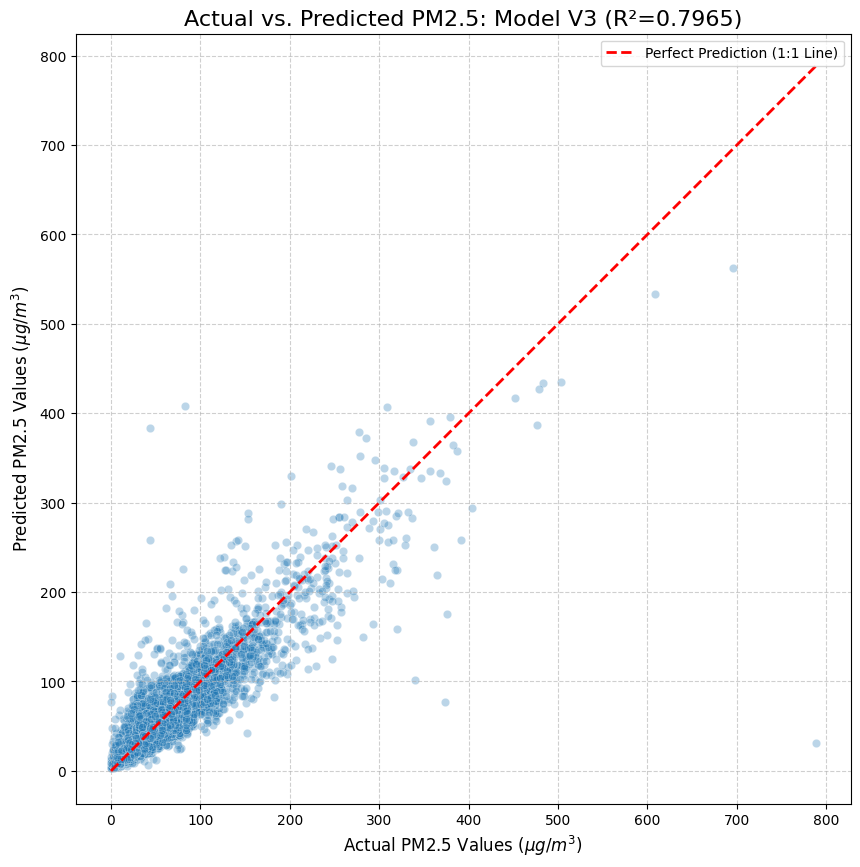

In [ ]:
# Create DataFrame for performance visualization
# Combine true values and model predictions into a single object
plot_df = pd.DataFrame({
    'Actual PM2.5': y_test_v3,
    'Predicted PM2.5': y_pred_rf_v3
})

# Generate scatterplot
# Use transparency (alpha) to reveal density in high-overlap areas
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=plot_df, 
    x='Actual PM2.5', 
    y='Predicted PM2.5',
    alpha=0.3
)

# Overlay perfect prediction line
# Calculate limits to ensure the 1:1 line spans the entire data range
max_val = max(plot_df['Actual PM2.5'].max(), plot_df['Predicted PM2.5'].max())
min_val = min(plot_df['Actual PM2.5'].min(), plot_df['Predicted PM2.5'].min())

plt.plot(
    [min_val, max_val], 
    [min_val, max_val], 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label='Perfect Prediction (1:1 Line)'
)

# Configure plot aesthetics and axis labels
# Include LaTeX units for professional scientific formatting
plt.xlabel('Actual PM2.5 Values ($\mu g/m^3$)', fontsize=12)
plt.ylabel('Predicted PM2.5 Values ($\mu g/m^3$)', fontsize=12)
plt.title(f'Actual vs. Predicted PM2.5: Model V3 (R²={r2_rf_v3:.4f})', fontsize=16)
plt.legend()
plt.axis('equal') # Maintain 1:1 aspect ratio for accurate visual assessment
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Model Comparison Summary

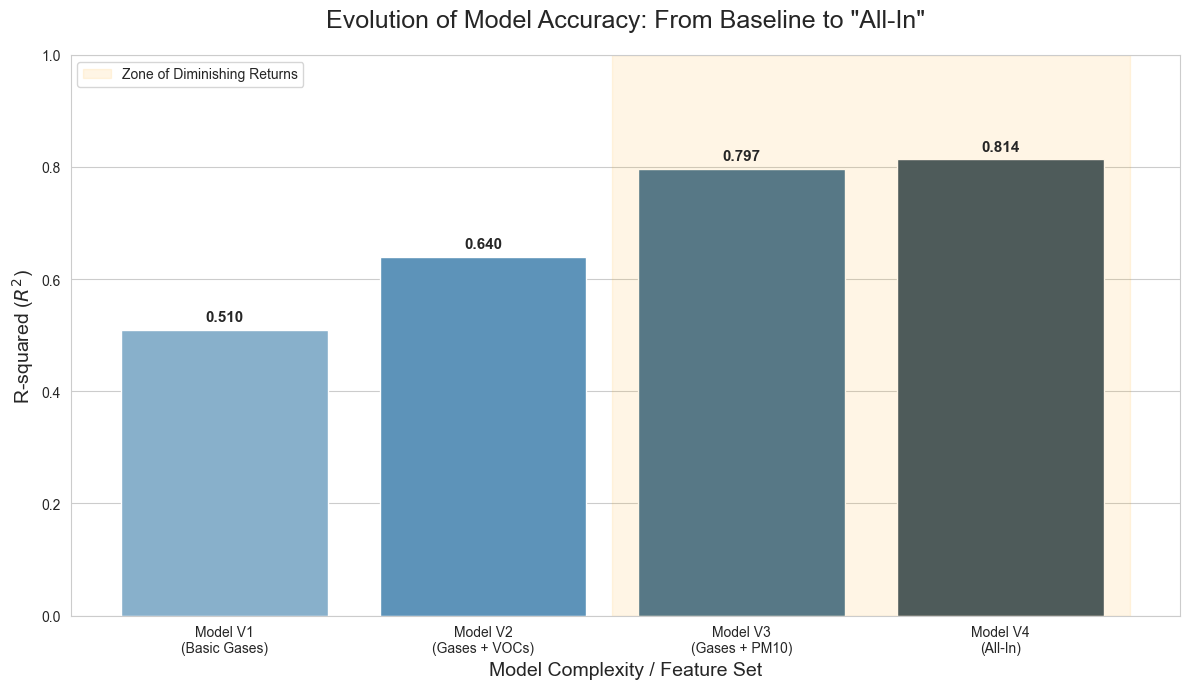

In [69]:
# Define performance data from regression experiments
# Use R-squared values recorded in the project discussion
model_names = ['Model V1\n(Basic Gases)', 'Model V2\n(Gases + VOCs)', 
               'Model V3\n(Gases + PM10)', 'Model V4\n(All-In)']
r2_values = [0.51, 0.64, 0.797, 0.814]

# Create a DataFrame for visualization
results_df = pd.DataFrame({
    'Model Configuration': model_names,
    'R-squared Score': r2_values
})

# Generate the bar chart
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Use a gradient palette to emphasize incremental improvement
# Assign hue to x and set legend=False to resolve deprecation warnings
barplot = sns.barplot(
    x='Model Configuration', 
    y='R-squared Score', 
    data=results_df, 
    hue='Model Configuration',
    palette='Blues_d',
    legend=False
)

# Add data labels to the top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.3f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontweight='bold',
                     fontsize=11)

# Highlight the zone of redundancy
# Mark the region where increased complexity yields diminishing returns
plt.axvspan(1.5, 3.5, color='orange', alpha=0.1, label='Zone of Diminishing Returns')

# Configure plot aesthetics
plt.title('Evolution of Model Accuracy: From Baseline to "All-In"', fontsize=18, pad=20)
plt.ylabel('R-squared ($R^2$)', fontsize=14)
plt.xlabel('Model Complexity / Feature Set', fontsize=14)
plt.ylim(0, 1.0) # Standardize Y-axis to the full R-squared range
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Trying a classification model to determine AQI bucket:

--- Training AQI Bucket Classifiers ---
Using 50000 rows for training.
Decision Tree Accuracy:  0.6674
Random Forest Accuracy: 0.7053

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

        Good       0.71      0.69      0.70      1151
    Moderate       0.73      0.82      0.77      4286
        Poor       0.52      0.20      0.28       619
Satisfactory       0.70      0.70      0.70      3375
      Severe       0.60      0.37      0.46        83
   Very Poor       0.60      0.47      0.53       486

    accuracy                           0.71     10000
   macro avg       0.64      0.54      0.57     10000
weighted avg       0.70      0.71      0.69     10000



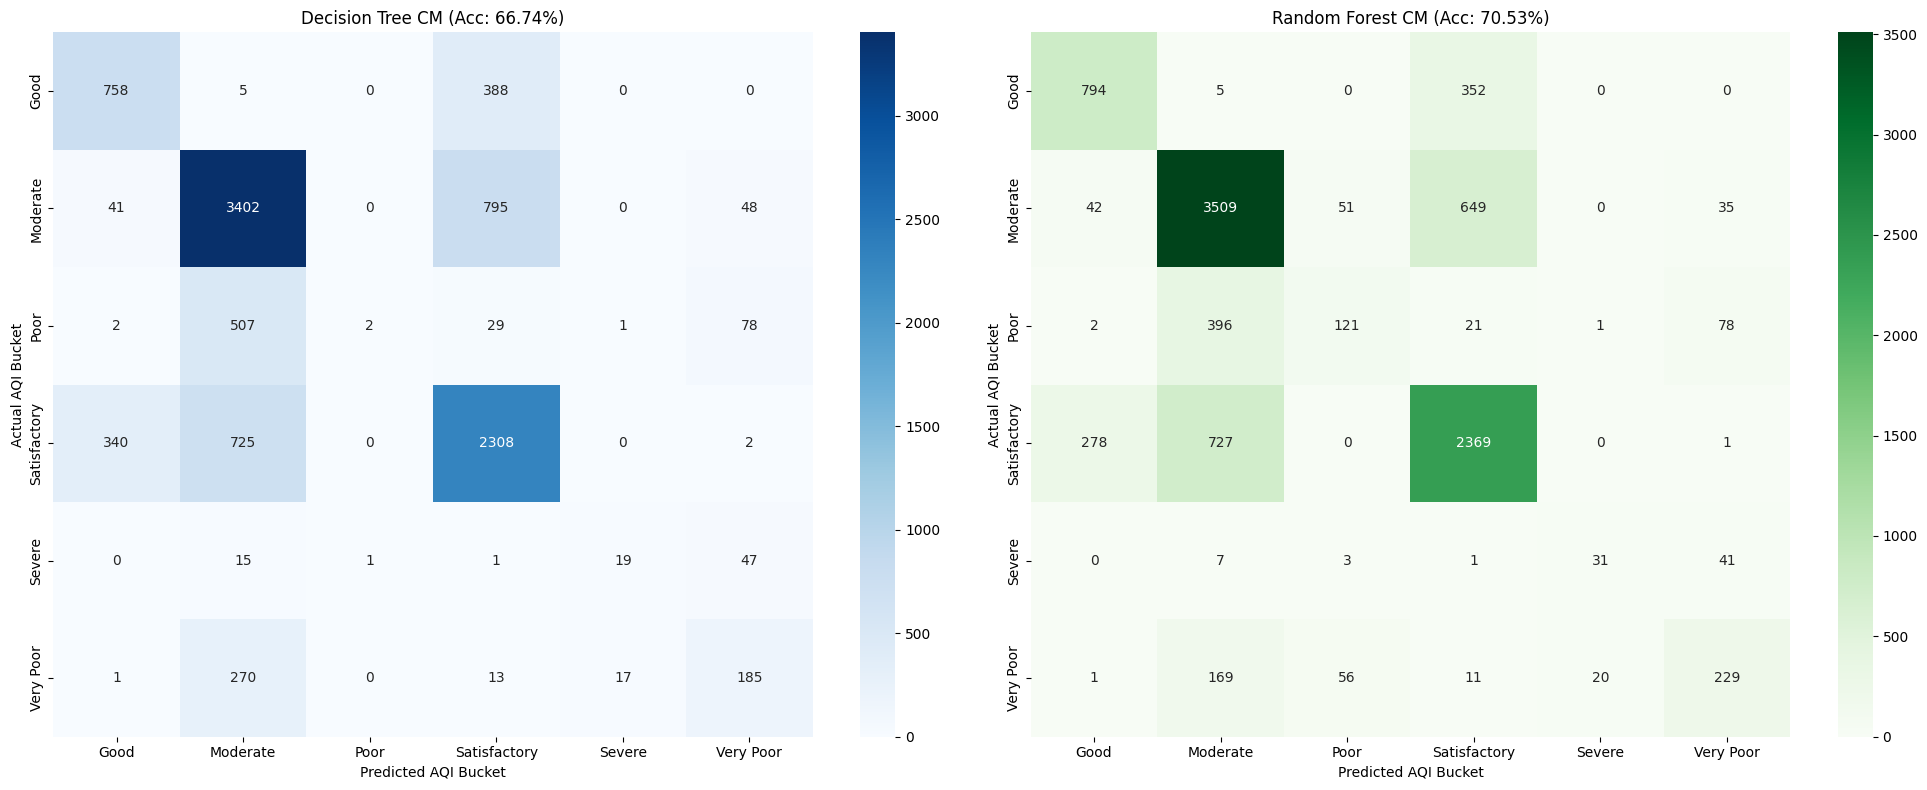

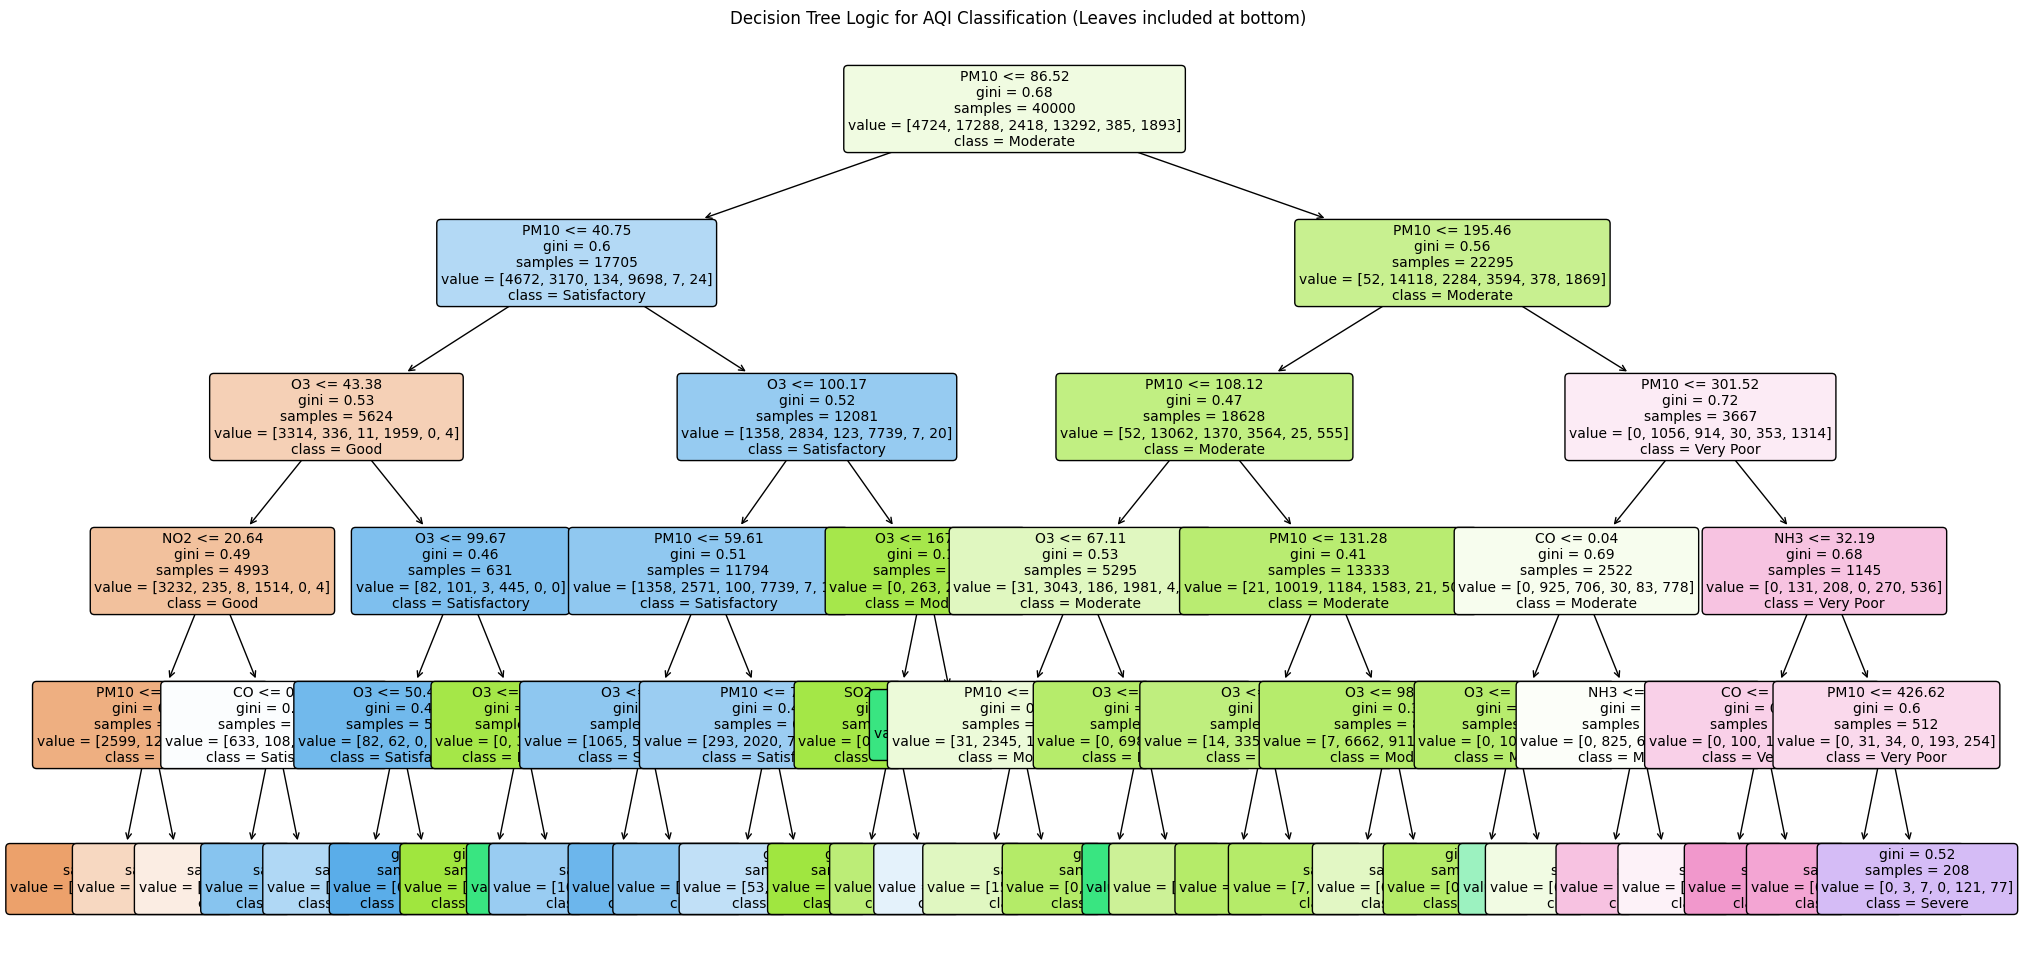

In [64]:
# Prepare data for classification
# Use Model V3 features for optimal efficiency and predictive power
features_list_class = ['NO2', 'CO', 'SO2', 'O3', 'NH3', 'PM10']
target_col_class = 'AQI_Bucket'

# Filter dataset and remove missing values for the classification task
model_data_class = reliable_station_hr_df[features_list_class + [target_col_class]].dropna()

# Sample the data to optimize training time
n_samples = 50000
if len(model_data_class) > n_samples:
    model_data_sample_class = model_data_class.sample(n=n_samples, random_state=42)
else:
    model_data_sample_class = model_data_class.copy()

print(f"--- Training AQI Bucket Classifiers ---")
print(f"Using {len(model_data_sample_class)} rows for training.")

# Assign feature and target variables
X_class = model_data_sample_class[features_list_class]
y_class = model_data_sample_class[target_col_class]

# Split data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# --- Model 1: Decision Tree (Baseline & Interpretability) ---
# Limit depth to 5 to maintain a balance between accuracy and visual clarity
tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_classifier.fit(X_train_c, y_train_c)

# Evaluate the Decision Tree
y_pred_tree = tree_classifier.predict(X_test_c)
tree_acc = accuracy_score(y_test_c, y_pred_tree)

# --- Model 2: Random Forest (Ensemble for Accuracy) ---
# Train a forest of 100 trees to reduce variance and improve robustness
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_c, y_train_c)

# Evaluate the Random Forest
y_pred_rf = rf_classifier.predict(X_test_c)
rf_acc = accuracy_score(y_test_c, y_pred_rf)

# Comparison Output
print(f"Decision Tree Accuracy:  {tree_acc:.4f}")
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# Generate detailed reports for both models
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test_c, y_pred_rf))

# Visualize the Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix for Decision Tree
cm_tree = confusion_matrix(y_test_c, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', 
            xticklabels=tree_classifier.classes_, 
            yticklabels=tree_classifier.classes_, ax=ax1)
ax1.set_title(f'Decision Tree CM (Acc: {tree_acc:.2%})')
ax1.set_xlabel('Predicted AQI Bucket')
ax1.set_ylabel('Actual AQI Bucket')

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test_c, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=rf_classifier.classes_, 
            yticklabels=rf_classifier.classes_, ax=ax2)
ax2.set_title(f'Random Forest CM (Acc: {rf_acc:.2%})')
ax2.set_xlabel('Predicted AQI Bucket')
ax2.set_ylabel('Actual AQI Bucket')

plt.tight_layout()
plt.show()

# Visualize the Decision Tree Logic
# Increased figure size and DPI to help make the leaf nodes (bottom row) more visible
plt.figure(figsize=(24, 12), dpi=100)
plot_tree(tree_classifier, 
          feature_names=features_list_class, 
          class_names=tree_classifier.classes_, 
          filled=True, 
          rounded=True, 
          fontsize=10,
          precision=2)
plt.title("Decision Tree Logic for AQI Classification (Leaves included at bottom)")
plt.show()

# Discussion

## Introduction & Summary of Data Understanding

The initial phase of this project involved a rigorous cleaning process to ensure analytical integrity. This included addressing data type warnings, parsing datetime objects, and handling missing values. Preliminary inspection of the time-series data revealed significant discontinuities in 2015 and 2016. To ensure accuracy, I established a reliable analytical window from January 1, 2017, to June 30, 2020. All subsequent insights and models are based on this continuous, high-quality dataset.

## Data Trends

**The Seasonal Air "Clensing" Effect**

The most dominant trend in the data is seasonal. The Seasonal Pollution figure clearly shows that AQI, PM2.5, and PM10 levels drop significantly during the monsoon months between June to September. The monsoons bring heavy wind and rainfall that blow pollutants away and wash it out with the rain. This is consistent with what is seen in the data, as once as once the dry season returns, there is a sharp increase in AQI. This is seen in the data, with levels often doubling from the low of September (the end of the monsoon) to the high of October (the beginning of the dry season). These extremes of climate and weather patterns show a seasonal cycle between Moderate to Unhealthy air quality index levels.

**Dinural Patterns and the 11:00 AM CO Divergence**

Analyzing hourly station averages reveals clear "rush-hour" peaks during 6–9 AM and 5–11 PM. However, a non-obvious divergence occurs around 11:00 AM. While $NO_2$ and $PM_{2.5}$ begin to decline due to photochemical reactions and rising atmospheric mixing, Carbon Monoxide (CO) exhibits a secondary peak.

* **Insight:** This suggests CO is the most sensitive marker for heavy-duty commercial vehicles, which are often permitted into city limits only after the primary morning passenger rush. Unlike $NO_2$, CO is chemically stable in sunlight, allowing it to accumulate even as other pollutants disperse.

**Feature Integrity: The $NO_x$ Proof**

Investigation into chemical relationships confirmed that $NO_x$ is not a simple arithmetic sum of NO and $NO_2$. By calculating the residuals between the recorded $NO_x$ and the calculated sum of its components, I identified a significant mean difference and a pronounced negative (left) skew in the distribution.

This statistical shift indicates a systematic "over-summing" where the combined values of NO and $NO_2$ frequently exceed the reported $NO_x$ total. This visual and mathematical proof confirms that $NO_x$ represents a distinct, separately measured chemical aggregate rather than a redundant mathematical calculation. This verification was essential for feature selection, ensuring the model incorporates $NO_x$ as a unique environmental indicator.

## Model Selection

### Regression Models for Predicting PM2.5

**Baseline & Model Evolution**

I began with a Linear Regression baseline to test for simple relationships. This model performed poorly ($R^2$: 0.38), proving the data relationships are non-linear and justifying the shift to a Random Forest Regressor (RFR).

* **Model V1 (Basic Gases):** Improved to an $R^2$ of 0.51 (RMSE: ~38.2). CO emerged as the strongest gaseous predictor.

* **Model V2 (Gases + VOCs):** Adding Benzene, Toluene, and Xylene pushed the $R^2$ to 0.64 (RMSE: ~32.1). This 25% jump confirms that VOCs provide a unique predictive signal for industrial emissions not captured by standard gases.

* **Model V3 (Gases + PM10):** Including $PM_{10}$ led to a massive performance leap, achieving an $R^2$ of 0.797 (RMSE: ~24.5).

* **Model V4 (The "All-In" Model):** Utilizing every available pollutant resulted in a final $R^2$ of 0.814 (RMSE: ~23.8).

**The Redundancy Insight**

A key finding emerged when comparing Model V3 and V4: the marginal gain from adding VOCs to a $PM_{10}$ model was only 0.017. This proves that once $PM_{10}$ is known, VOC data becomes statistically redundant. Therefore, Model V3 represents the optimal balance of efficiency and accuracy for real-world deployment.

### Classification Model for Predicting AQI Level

I compared a baseline Decision Tree against an ensemble Random Forest to predict health categories.

* **Model Performance:** The Random Forest achieved superior accuracy compared to the single Decision Tree. Specifically, the ensemble method significantly reduced "neighbor confusion" between borderline categories. For instance, the RF model reduced instances of misclassifying 'Moderate' as 'Satisfactory' by approximately 150 records.

* **The Logic of Errors:** Most remaining errors occur at the sharp boundaries of the AQI buckets. This is an expected limitation, as a single unit of pollution can trigger a category change.

* **Safety Profile:** Critically, both models demonstrated a perfect safety profile by making zero catastrophic errors (e.g., confusing 'Good' with 'Severe'). This makes the classifier a reliable tool for automated public health advisories.

## Conclusion and Further Applications

1. **Virtual Sensors:** The high-performing RFR models (V3/V4) can function as "virtual sensors," accurately estimating $PM_{2.5}$ during hardware failures.

2. **Policy Implications:** The link between traffic pollutants (CO, $NO_2$) and AQI peaks suggests that interventions targeting commercial traffic cycles would have the most direct impact on urban air quality.

3. **Future Development:** The remaining ~19% of variance in our best model is likely due to unmeasured weather factors (wind speed, humidity). Future iterations should merge this dataset with historical meteorological records to reach even higher precision.
